# AgeDB
## Purpose
In this notebook, we will analyze the content of the AgeDB database.

# Setup

## Library import
We import all the required Python libraries

In [20]:
# Core
import torch
from torch.utils.data import DataLoader

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import data_table
from PIL import Image
sns.set_theme(context='notebook', style='darkgrid', palette='pastel')

# General
import math
import os
from glob import glob
from random import randint

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Parameter definition
We set all relevant parameters for our notebook.

In [18]:
## General
# Set the device to a GPU if available.
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {DEVICE}')
# Set the number of workers depending on the os.
WORKERS = 0 if os.name == 'nt' else 4
print(f'N. of workers: {WORKERS}')


Running on device: cpu
N. of workers: 4


# Data

## Data import

The instructions to follow to retrieve the AgeDB dataset are [here](https://ibug.doc.ic.ac.uk/resources/agedb/).

## Data visualization
To visualize the data, we write a some methods. The method `get_annotations` extract from the filename the information about the person, `get_image` retrieve an image at random or at index, `get_images` returns all of the paths of the images of the specified class.

In [4]:
def get_annotations(img_path):
  """Decompose the filename of an image to get its annotations.
  
    Arguments:
      img_path (string): Path to the image.
    
    Returns:
      annotations (list): Contains (in order) img_id, subject_name, age, gender.
  """
  # Keep only the filename and remove the directories.
  img_name = img_path.split('\\\\')[-1]

  # Remove the extension.
  img_name = img_name[:-4]

  # Get the different notes by splitting on the underscore.
  fields = img_name.split('_')

  # Convert the img_id and the age to integer.
  fields = [int(fields[0]), fields[1], int(fields[2]), fields[3]]

  return fields

def get_image(id=-1):
  """Retrieve an image from the database. If no id is passed, then the image
  is taken at random.

    Arguments:
      id (int): id of the image.
    
    Returns:
      img_path (string): path to the image.
  """

  # Get the list of all of the images.
  images = glob('AgeDB/*.jpg')

  # Check that the index valid.
  assert id <= len(images)

  # If no index, set it randomly.
  if id == -1:
    id = randint(0, len(images))

  # Generate the list of all the indices.
  indices = [get_annotations(image)[0] for image in images]

  # Return the path to the image.
  return images[indices.index(id)]

def get_images(ids=None, class_name=None):
  """Return all of the images of the specified identity.

    Arguments:
      ids (list): ids of the images to retrieve.
      class_name (string): identity of the person.
    
    Returns
      img_paths (list): list of paths to the images.
  """
  img_paths = []

  # If class_name is defined.
  if class_name != None:
    # Get the list of all of the images.
    images = glob('AgeDB/*.jpg')

    # If the path contains the name of the class, then it's an image of the class.
    img_paths = [image for image in images if class_name in image]
  # If ids are defined instead.
  elif ids != None:
    # Get the list of paths with the get_image method.
    img_paths = [get_image(id) for id in ids]

  return img_paths


The code below is used to show a single image specified by index or path, or taken at random.

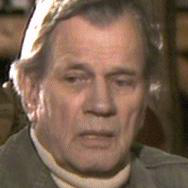

In [5]:
def show_image(id=None, img_path=None):
  """Show an image. If no path to an image or id is passed, then the image is
  retrieved at random.

    Arguments:
      id (int): id of the image to show.
      img_path (string): path to an image.
    
    Returns:
      img (JpegImageFile): image in JPG format.
  """

  # If no path to image, check the id.
  if img_path == None:
    # If no id, get a random one.
    if id == None:
      img_path = get_image()
    else:
      img_path = get_image(id=id)
  
  # Return a JpegImageFile
  return Image.open(img_path)

show_image()


Moreover, we write another method to show a batch of faces with their information. If we don't pass any 

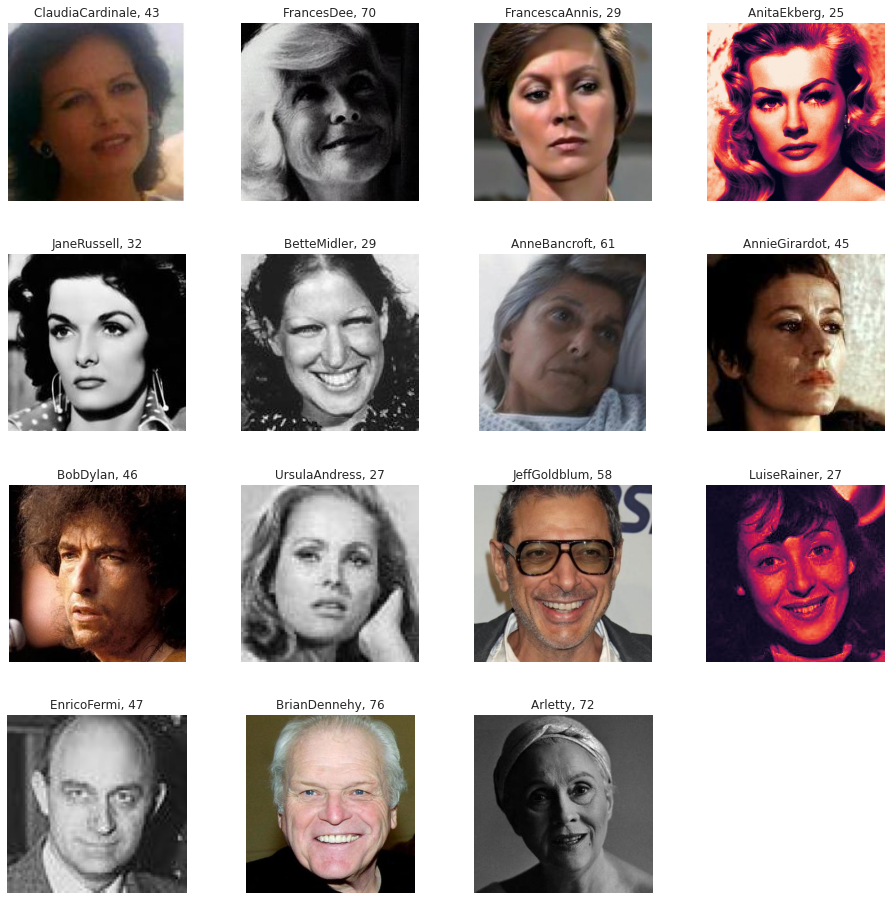

In [8]:
def show_images(ids=None, img_paths=None, n=9,
                extra_info=None, show_title=True):
  """Show a batch of images.

    Arguments:
      ids (list): 
      img_paths (list):
      n (int): total number of images to show. If ids or paths are passed, it
        is automatically evaluated.
      show_title (bool): add name and age of person as title to each image.
      extra_info (list): add extra line of information in the title of each
        image. The dimension of the list must match either the dimension of the
        ids or the img_paths.
  """

  # If the ids or the paths to the images are passed, overwrite the value of
  # size.
  if ids != None:
    size = math.ceil(math.sqrt(len(ids)))
    stop = len(ids) + 1
  elif img_paths != None:
    size = math.ceil(math.sqrt(len(img_paths)))
    stop = len(img_paths) + 1
  else:
    size = math.ceil(math.sqrt(n))
    stop = n + 1

  # Create a new figure.
  fig = plt.figure(figsize=(size*4, size*4))

  # Set the horizontal space between subplots.
  plt.subplots_adjust(hspace=0.3)

  for i in range(1, stop):
    # If ids are passed, load the image defined by the id.
    if ids != None:
      img_path = get_image(id=ids[i-1])
    # If paths are passed instead, set the img_path to the current path.
    elif img_paths != None:
      img_path = img_paths[i-1]
    # Otherwise, get a random image.
    else:
      img_path = get_image()

    # Add the image as a subplot.
    fig.add_subplot(size, size, i)
    plt.imshow(Image.open(img_path))

    # Hide axis.
    plt.axis('off')

    # Add title, if needed.
    if show_title:
      # Retrieve the annotations of the image.
      annotation = get_annotations(img_path)

      # Define the suffix, if needed.
      suffix = f"\n {extra_info[i-1]}" if extra_info != None else ""
      
      # Set the title of the figure to the name and the age of the person.
      plt.title(f'{annotation[1]}, {annotation[2]}{suffix}')
  
  # Show the plot.
  plt.show()

show_images(n=15)


## Data analysis

To analyze the dataset, we can instantiate a dataframe containing the annotations and the paths for each image.

In [9]:
# Get all the images in the dataset.
agedb_images = glob('AgeDB/*.jpg')

# Get the annotations for all of the images.
agedb_annotations = [get_annotations(image) for image in agedb_images]

# Merge the two lists.
db = [[*agedb_annotations[i], agedb_images[i]] for i in range(len(agedb_images))]

# Create the DataFrame and reindex it to use the id as the index.
agedb_df = pd.DataFrame(data=db, 
                        columns=['Id', 'Name', 'Age', 'Gender', 'Path'])

# Show the dataframe.
data_table.DataTable(agedb_df, num_rows_per_page=10, include_index=False)


We can evaluate some statistics to understand better how's the AgeDB dataset. Some metrics we could evaluate are the distributions of ages and gender. 

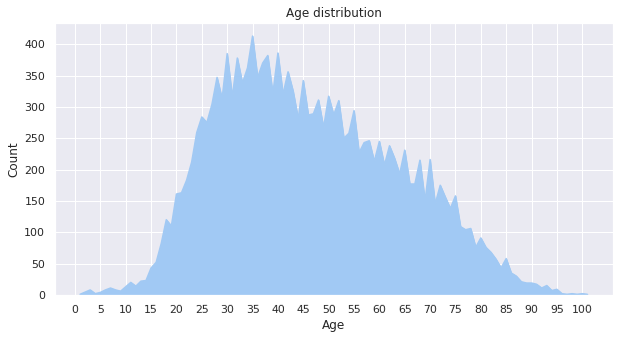

In [10]:
fig = agedb_df[['Id', 'Age']].groupby(by='Age').count() \
        .plot(figsize=(10, 5),
              kind='area',
              legend=False,
              rot=1,
              title='Age distribution',
              xticks=[i*5 for i in range(0, 21)],
              ylabel='Count')

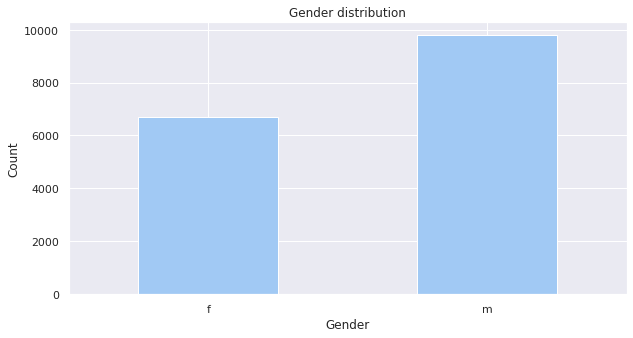

In [11]:
fig = agedb_df[['Id', 'Gender']].groupby(by='Gender').count() \
        .plot(figsize=(10, 5),
              kind='bar',
              legend=False,
              rot=1,
              title='Gender distribution',
              ylabel='Count')

## Dataset definition
Below, we define a Dataset and a DataLoader class for the AgeDB dataset. For now, we can use a simple implementation. Indeed, a Dataset must implement only the `__len__()` and the `__getitem__()` methods, therefore a `list` object do the trick. To reduce the dimension of the dataset, we can pass the number of classes we'd like to have to the `get_dataset()` method.

In [13]:
def get_dataset(classes=-1):
  """Return a list containing pairs of image paths and annotations.
  
    Arguments:
      classes (int): number of classes to consider. If not specified, the
        dataset will contain every class (aka: person identity).
    
    Returns:
      dataset (list): list representing the Dataset class.
  """
  # Get the list of all of the images.
  images = glob('AgeDB/*.jpg')

  # Save the list of annotations for each image.
  annotations = [get_annotations(image) for image in images]

  # If no positive number of classes is specified, return the complete dataset.
  if classes <= 0:
    return list(zip(images, annotations))

  # Maintain only the set of names.
  names = list(set([annotation[1].strip() for annotation in annotations]))

  assert classes <= len(names)

  # Maintain only the specified number of different names.
  names = names[:classes]

  dataset = []

  for i, annotation in enumerate(annotations):
    name = annotation[1].strip()

    if name in names:
      dataset.append([images[i], annotation])

  return dataset


In [14]:
dataset = get_dataset(classes=3)


For the DataLoader, we simply instantiate it directly.

In [21]:
def get_dataloader(dataset=None, num_workers=WORKERS):
  """Return a dataloader.
  
    Arguments:
      dataset (Dataset): target of the loader. If not specified, a new dataset
        is generated automatically.
      num_workers: number of workers.
    
    Returns:
      loader (Dataloader): loader applied on the specified dataset.
  """

  # Define the collate function to use.
  def collate_fn(x):
    return x[0]
  
  # If no dataset is passed, instantiate it directly.
  if dataset == None:
    dataset = get_dataset()

  # Return the dataloader.
  return DataLoader(dataset, collate_fn=collate_fn, num_workers=WORKERS)

loader = get_dataloader(dataset)


# References
We report here relevant references:

 1. Moschoglou, S., Papaioannou, A., Sagonas, C., Deng, J., Kotsia, I., & Zafeiriou, S. (2017). AgeDB: The First Manually Collected, In-the-Wild Age Database. In IEEE Computer Society Conference on Computer Vision and Pattern Recognition Workshops (Vols. 2017-July). https://doi.org/10.1109/CVPRW.2017.250